In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('usd_curve.csv')
times = data['t'].values
df = data['df'].values

class HullWhite():
    def __init__(self, a, sigma, timesteps, x0=0):
        self.a = a
        self.sigma = sigma
        self.timesteps = timesteps
        self.x0 = x0
        
    def hw_exp(self, x, t1, t2):
        return x * np.exp(-self.a * (t2 - t1))
    
    def hw_var(self, t1, t2):
        return self.sigma ** 2 * (1 - np.exp(-2 * self.a * (t2 - t1))) / (2 * self.a)

    def MC(self, sims):
        x = np.zeros((sims, self.timesteps))
        for i in range(sims):
            x[i,0] = self.x0
            for j in range(1, self.timesteps):
                Z1 = np.random.normal(0,1)
                x[i,j] = self.hw_exp(x[i,j-1], j-1, j) + Z1 * (self.hw_var(j-1,j) ** 0.5)
        return x     
    


In [9]:
class DiscountFactors():
    def __init__(self, a, sigma):
        self.a = a
        self.sigma = sigma
        
    def q_t(self, t, T):
         return (1 - np.exp(-self.a * (T - t))) / self.a

    def cov(self, t_i, t_j):
        return self.sigma ** 2 * (np.exp(-self.a * abs(t_j - t_i)) - np.exp(-self.a * (t_j + t_i))) / (2 * self.a)
 
    def hw_phi(self, q_val, cov_val):
        return sum(q * cov for q, cov in zip(q_values, cov_values))

    def hw_gamma(self, tn):
        return 0.5 * self.cov(tn, tn)

    def interpolated_df(self, t, time, df):
        return np.interp(t, time, df)
    
    def df(self, t_n, T, x_tn, q_val, cov_val):
        B_tn = self.interpolated_df(t_n, times, df)
        B_T = self.interpolated_df(T, times, df)
        if t_n == 0:
            discount_factor = B_T / B_tn 
        else:
            phi = self.hw_phi(q_val, cov_val)
            gamma = self.hw_gamma(t_n)
            q_tn = self.q_t(t_n, T)
            discount_factor = (B_T / B_tn) * np.exp(-(x_tn + phi) * q_tn - gamma * (q_tn ** 2))
        return discount_factor
        

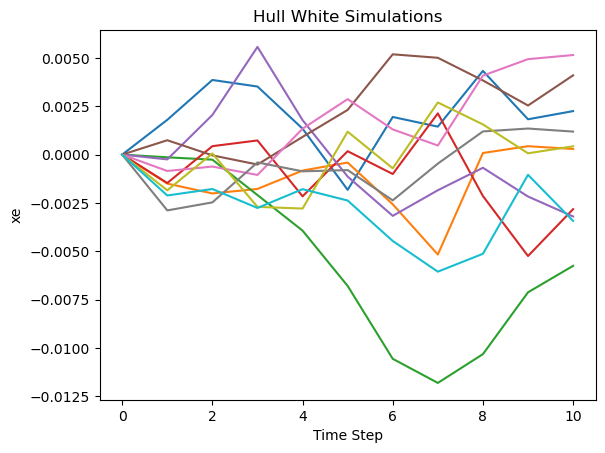

In [23]:
# Testing Hull White

a = 0.1
x0 = 0
sigma = 0.002

timesteps = 10

# MC Parameters
sims = 10
T = 10
dt = T / timesteps  
hw_timesteps = int(T / dt) + 1

hw = HullWhite(a, sigma, hw_timesteps, x0)
simulated_paths = hw.MC(sims)
hwdf = DiscountFactors(a, sigma)

#print (simulated_paths)
#print (hw_timesteps)
#print (dt)

for i in range(sims):
    plt.plot(simulated_paths[i])
plt.xlabel('Time Step')
plt.ylabel('xe')
plt.title('Hull White Simulations')
plt.show()

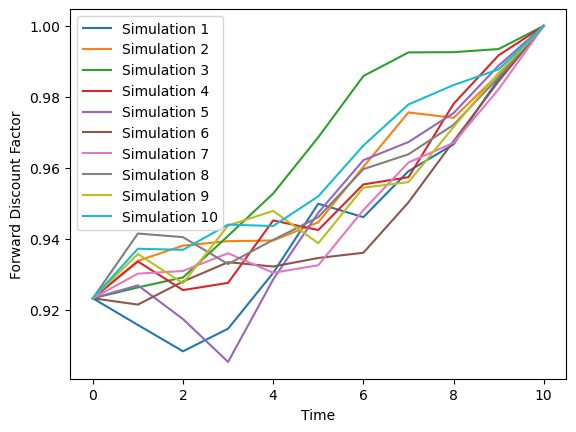

In [29]:
q_values = []
cov_values = []
for x in range(timesteps + 1):
    q_val1 = hwdf.q_t(x, x + 1)
    cov1 = hwdf.cov(x, timesteps + 1)
    q_values.append(q_val1)
    cov_values.append(cov1)

result = sum(q * cov for q, cov in zip(q_values, cov_values))

for i in range(sims):
    x_tn_values = simulated_paths[i]

    for t_n in range(hw_timesteps):
        t = t_n * dt  
        T = T         
        q_val = hwdf.q_t(t, T)
        cov_val = hwdf.cov(t, T)
        discount_factor = hwdf.df(t, T, x_tn_values[t_n], q_val, cov_val)  
        
discount_factors = np.zeros((sims, hw_timesteps))        

       
for i in range(sims):
    x_tn_values = simulated_paths[i]
    for t_n in range(hw_timesteps):
        t = t_n * dt  
        T = T      
        q_val = hwdf.q_t(t, T)
        cov_val = hwdf.cov(t, T)
        discount_factors[i, t_n] = hwdf.df(t, T, x_tn_values[t_n], q_val, cov_val)

#print(discount_factors)        
       
for i in range(sims):
    plt.plot(np.arange(hw_timesteps) * dt, discount_factors[i], label=f'Simulation {i+1}')

plt.xlabel('Time')
plt.ylabel('Forward Discount Factor')
plt.legend()
plt.show()